In [46]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
from datetime import datetime
device = 'cuda'


In [47]:
data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)
X_test_3 = torch.stack([img for img, _ in cifar10_test], dim=3).view(3, -1).to(device=device)
Y_test_3 = torch.tensor([label for _, label in cifar10_test]).to(device=device)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [48]:
class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, average='weighted'),
            'recall': recall_score(Y_test, Y_pred, average='weighted'),
            'f1': f1_score(Y_test, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')

In [49]:
input_dim = 32
conv_layers = [16, 8]
fc_layers = [32, 10]

stack = nn.Sequential(OrderedDict(
    [
        ('conv0', nn.Conv2d(in_channels=3, out_channels=conv_layers[0], kernel_size=3, padding=1)),
        ('relu0', nn.ReLU()),
        ('maxpool0', nn.MaxPool2d(2)),
    ]
))

for i in range(1, len(conv_layers)):
    stack.add_module(f'conv{i}', nn.Conv2d(in_channels=conv_layers[i-1], out_channels=conv_layers[i], kernel_size=3, padding=1))
    stack.add_module(f'relu{i}', nn.ReLU())
    stack.add_module(f'maxpool{i}', nn.MaxPool2d(2))
    
conv_out = input_dim//(2**len(conv_layers))
stack.add_module('flatten', nn.Flatten())
stack.add_module(f'fc0', nn.Linear(conv_out**2*conv_layers[-1], fc_layers[0]))

for i in range(1, len(fc_layers)):
    stack.add_module(f'relu_fc{i}', nn.ReLU())
    stack.add_module(f'fc{i}', nn.Linear(fc_layers[i-1], fc_layers[i]))        

stack

Sequential(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=512, out_features=32, bias=True)
  (relu_fc1): ReLU()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)

In [50]:
class ConvImageClassifier(Classifier):
    def __init__(self, input_dim, conv_layers, fc_layers, activation=nn.ReLU):
        super().__init__()
        
        self.stack = nn.Sequential(OrderedDict(
            [
                ('conv0', nn.Conv2d(in_channels=3, out_channels=conv_layers[0], kernel_size=3, padding=1)),
                ('activation0', activation()),
                ('maxpool0', nn.MaxPool2d(2)),
            ]
        ))
        
        for i in range(1, len(conv_layers)):
            self.stack.add_module(f'conv{i}', nn.Conv2d(in_channels=conv_layers[i-1], out_channels=conv_layers[i], kernel_size=3, padding=1))
            self.stack.add_module(f'activation{i}', activation())
            self.stack.add_module(f'maxpool{i}', nn.MaxPool2d(2))
            
        conv_out = input_dim//(2**len(conv_layers))
        self.stack.add_module('flatten', nn.Flatten())
        self.stack.add_module(f'fc0', nn.Linear(conv_out**2*conv_layers[-1], fc_layers[0]))
        
        for i in range(1, len(fc_layers)):
            self.stack.add_module(f'activation_fc{i}', activation())
            self.stack.add_module(f'fc{i}', nn.Linear(fc_layers[i-1], fc_layers[i]))        
        
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        alpha,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=10,
    ):  
        optimizer = optimizer(self.parameters(), lr=alpha)
        training_time = 0
        train_hist = np.zeros(epochs)
        test_hist = np.zeros(epochs)
        accuracy_hist = np.zeros(epochs)
        for epoch in range(epochs):
            begin_epoch = time.time()
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            training_time += time.time() - start_time
            train_hist[epoch] = train_loss/len(train_loader)
            
            
            self.eval()
            with torch.no_grad():
                test_loss = 0
                Y_pred_eval = []
                Y_test = []
                for X_test_batch, Y_test_batch in test_loader:
                    X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch).item()
                    Y_test.extend(Y_test_batch.cpu().detach().numpy())
                    Y_pred_eval.extend(out.argmax(dim=1).cpu().detach().numpy())
                
            test_hist[epoch] = test_loss/len(test_loader)
            accuracy_hist[epoch] = accuracy_score(Y_test, Y_pred_eval)
            if epoch % print_epoch == 0 or epoch == epochs - 1:
                end_epoch = time.time()
                print(f'Epoch {epoch}: Training Loss: {train_hist[epoch]}, Test Loss: {test_hist[epoch]}, Accuracy: {accuracy_hist[epoch]}, Epoch Duration: {(end_epoch - begin_epoch):2f} seconds')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_test = torch.tensor(Y_test)
        print(f'\nTraining Time: {training_time} seconds\n')
        
        self.train_hist = train_hist
        self.test_hist = test_hist
        self.accuracy_hist = accuracy_hist
    
    def plot_training(self, title='Training Results'):
        plt.plot(self.train_hist, label='Training Loss')
        plt.plot(self.test_hist, label='Test Loss')
        plt.plot(self.accuracy_hist, label='Accuracy')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

            
            

Sequential(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=512, out_features=32, bias=True)
  (activation_fc1): ReLU()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Epoch 0: Training Loss: 2.068884416766789, Test Loss: 1.8502755134728304, Accuracy: 0.3422, Epoch Duration: 14.315109 seconds
Epoch 1: Training Loss: 1.7244827690941598, Test Loss: 1.648571524650428, Accuracy: 0.4056, Epoch Duration: 14.064831 seconds
Epoch 2: Training Loss: 1.5388323030508388, Test Loss: 1.5282564110057368, Accuracy: 0.4447, Epoch Duration: 14.862737 seconds

Training Time: 36.97473382949829 s

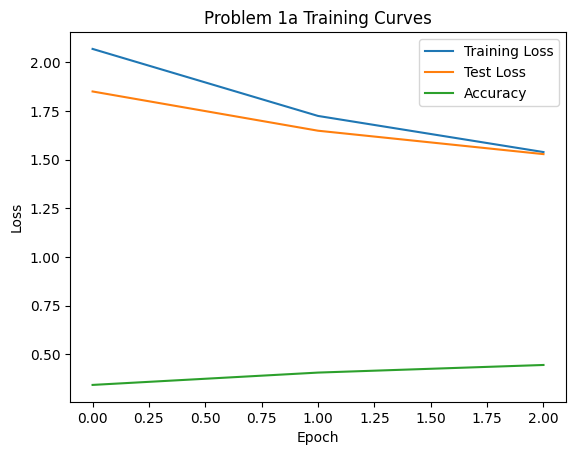

In [51]:
model_1a = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[16, 8],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)

print(model_1a.stack)

model_1a.train_model(
    epochs=3,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=1e-2,
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)

model_1a.get_results()
model_1a.print_results()
model_1a.plot_training("Problem 1a Training Curves")
